# Fine-tuning Granite Vision 3.1 2B with TRL

_Authored by: [Eli Schwartz](https://huggingface.co/elischwartz)_

Adapted from [Sergio Paniego](https://github.com/sergiopaniego)'s [Notebook](https://huggingface.co/learn/cookbook/en/fine_tuning_smol_vlm_sft_trl)


This recipe will enable you to fine-tune [IBM's Granite Vision 3.1 2B Model](https://huggingface.co/ibm-granite/granite-vision-3.1-2b-preview).
It is a lightweight yet capable model trained by fine-tuning a [Granite language model](https://huggingface.co/ibm-granite/granite-3.1-2b-instruct) with both image and text modalities.
We will be using the Hugging Face ecosystem, leveraging the powerful [Transformer Reinforcement Learning library (TRL)](https://huggingface.co/docs/trl/index). This step-by-step guide will enable you to Granite Vision for your specific tasks, even on consumer GPUs.

### 🌟 Model & Dataset Overview

In this notebook, we will fine-tune and evaluate the **[Granite Vision](https://huggingface.co/ibm-granite/granite-vision-3.1-2b-preview)** model using the **[Geometric Perception](https://huggingface.co/datasets/euclid-multimodal/Geoperception)** dataset, containing tasks that the model wasn't intially trained for. Granite Vision is a highly performant and memory-efficient model, making it an ideal for fine tuning for new tasks. The **Geometric Perception** provides images of various geometric diagrams, compiled from high-school textbooks, paired with question-answer pairs.


This notebook is tested using a A100 GPU.

## 1. Install Dependencies

Let’s start by installing the essential libraries we’ll need for fine-tuning! 🚀


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install  -U -q trl datasets bitsandbytes peft accelerate
# Tested with transformers==4.49.0.dev0, trl==0.14.0, datasets==3.2.0, bitsandbytes==0.45.2, peft==0.14.0, accelerate==1.3.0

In [ ]:
!pip install -q flash-attn --no-build-isolation

try:
    import flash_attn
    print("FlashAttention is installed")
    USE_FLASH_ATTENTION = True
except ImportError:
    print("FlashAttention is not installed")
    USE_FLASH_ATTENTION = False

FlashAttention is not installed


## 2. Load Dataset 📁

We’ll load the **[Geometric Perception](https://huggingface.co/datasets/euclid-multimodal/Geoperception)** dataset, which provides images of various geometric diagrams, compiled from popular high-school textbooks, paired with question-answer pairs.

We’ll use the original system prompt used during the model training.

In [ ]:
system_message = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions."

For educational purposes, we’ll only train and evaluate on the Line Length Comaprison task, specified in the "predicate" field of the dataset.

In [ ]:
from datasets import load_dataset

dataset_id = "euclid-multimodal/Geoperception"
dataset = load_dataset(dataset_id)
dataset_LineComparison = dataset['train'].filter(lambda x: x['predicate'] == 'LineComparison')
train_test = dataset_LineComparison.train_test_split(test_size=0.5, seed=42)

Let’s take a look at the dataset structure. It includes an image, a question, an answer, and "predicate" which we used to filter the dataset.

In [ ]:
train_test

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'answer', 'predicate', 'image'],
        num_rows: 697
    })
    test: Dataset({
        features: ['id', 'question', 'answer', 'predicate', 'image'],
        num_rows: 697
    })
})

We’ll format the dataset into a chatbot structure, with the system message, image, user query, and answer for each interaction.

💡For more tips on using this model for inference, check out the [Model Card](https://huggingface.co/ibm-granite/granite-vision-3.1-2b-preview).

In [ ]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": system_message
                }
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample['question'],
                }
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": sample["answer"]
                }
            ],
        },
    ]

Now, let’s format the data using the chatbot structure. This will set up the interactions for the model.

In [ ]:
train_dataset = [format_data(x) for x in train_test['train']]
test_dataset = [format_data(x) for x in train_test['test']]

In [ ]:
train_dataset[200]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions."}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=519x431>},
   {'type': 'text', 'text': 'Which line is longer, AC or BA?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'BA'}]}]

## 3. Load Model and Check Performance! 🤔

Now that we’ve loaded the dataset, it’s time to load the [IBM's Granite Vision Model](https://huggingface.co/ibm-granite/granite-vision-3.1-2b-preview), a 2B parameter Vision Language Model (VLM) built on that offers state-of-the-art (SOTA) performance while being efficient in terms of memory usage.

For a broader comparison of state-of-the-art VLMs, explore the [WildVision Arena](https://huggingface.co/spaces/WildVision/vision-arena) and the [OpenVLM Leaderboard](https://huggingface.co/spaces/opencompass/open_vlm_leaderboard), where you can find the best-performing models across various benchmarks.


In [ ]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor

model_id = "ibm-granite/granite-vision-3.1-2b-preview"

Next, we’ll load the model and the tokenizer to prepare for inference.

In [ ]:
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2" if USE_FLASH_ATTENTION else None,
)

processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


To evaluate the model's performance, we’ll use a sample from the dataset. First, let’s inspect the internal structure of this sample to understand how the data is organized.

In [ ]:
test_idx = 20
sample = test_dataset[test_idx]
sample

[{'role': 'system',
  'content': [{'type': 'text',
    'text': "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions."}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=691x412>},
   {'type': 'text', 'text': 'Which line is longer, AC or BD?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'BD'}]}]

Now, let’s take a look at the image corresponding to the sample. Can you answer the query based on the visual information?


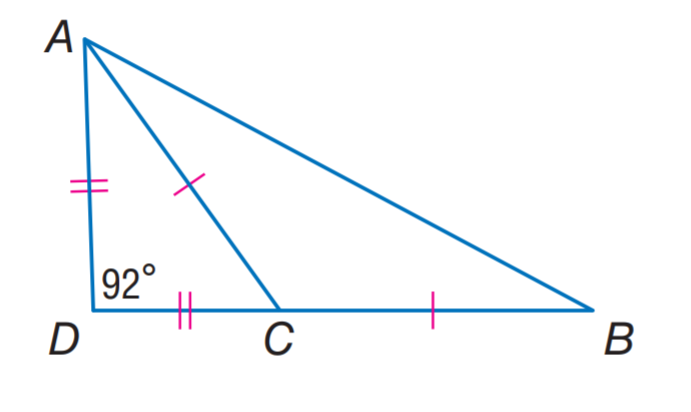

In [ ]:
sample[1]['content'][0]['image']

Let’s create a method that takes the model, processor, and sample as inputs to generate the model's answer. This will allow us to streamline the inference process and easily evaluate the VLM's performance.

In [ ]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=100, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[:2],  # Use the sample without the assistant response
        add_generation_prompt=True
    )

    image_inputs = []
    image = sample[1]['content'][0]['image']
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_inputs.append([image])

    # Prepare the inputs for the model
    model_inputs = processor(
        #text=[text_input],
        text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [ ]:
output = generate_text_from_sample(model, processor, sample)
output

'The length of line segment AC is not explicitly provided in the given information, so it cannot be determined which line is longer between AC and BD.'

It seems like the model is unable to comapre the lines' lengths which are not explicitly specified. To improve its performance, we can fine-tune the model with more relevant data to ensure it better understands the context and provides more accurate responses.

**Remove Model and Clean GPU**

Before we proceed with training the model in the next section, let's clear the current variables and clean the GPU to free up resources.



In [ ]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 0.02 GB


## 4. Fine-Tune the Model using TRL


### 4.1 Load the Quantized Model for Training ⚙️

Next, we’ll load the quantized model using [bitsandbytes](https://huggingface.co/docs/bitsandbytes/main/en/index). If you want to learn more about quantization, check out [this blog post](https://huggingface.co/blog/merve/quantization) or [this one](https://www.maartengrootendorst.com/blog/quantization/).


In [ ]:
from transformers import BitsAndBytesConfig

USE_QLORA = True
USE_LORA = True

if USE_QLORA:
    # BitsAndBytesConfig int-4 config
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        llm_int8_skip_modules=["vision_tower", "lm_head"],  # Skip problematic modules
        llm_int8_enable_fp32_cpu_offload=True
    )
else:
    bnb_config = None

# Load model and tokenizer
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    _attn_implementation="flash_attention_2" if USE_FLASH_ATTENTION else None,
)
processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 4.2 Set Up QLoRA and SFTConfig 🚀

Next, we’ll configure [QLoRA](https://github.com/artidoro/qlora) for our training setup. QLoRA allows efficient fine-tuning of large models by reducing the memory footprint. Unlike traditional LoRA, which uses low-rank approximation, QLoRA further quantizes the LoRA adapter weights, leading to even lower memory usage and faster training.

To boost efficiency, we can also leverage a **paged optimizer** or **8-bit optimizer** during QLoRA implementation. This approach enhances memory efficiency and speeds up computations, making it ideal for optimizing our model without sacrificing performance.

In [ ]:
if USE_LORA:
    from peft import LoraConfig, get_peft_model
    
    # Configure LoRA
    peft_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules=[name for name, _ in model.named_modules() if 'language_model' in name and '_proj' in name],
        use_dora=True,
        init_lora_weights="gaussian"
    )
    
    # Apply PEFT model adaptation
    # model = get_peft_model(model, peft_config)
    model.add_adapter(peft_config)
    model.enable_adapters()
    model = get_peft_model(model, peft_config)
    
    # Print trainable parameters
    model.print_trainable_parameters()
    
else:
    peft_config = None

We will use Supervised Fine-Tuning (SFT) to improve our model's performance on the specific task. To achieve this, we'll define the training arguments with the [SFTConfig](https://huggingface.co/docs/trl/sft_trainer) class from the [TRL library](https://huggingface.co/docs/trl/index). SFT leverages labeled data to help the model generate more accurate responses, adapting it to the task. This approach enhances the model's ability to understand and respond to visual queries more effectively.

In [ ]:
from trl import SFTConfig

# Configure training arguments using SFTConfig
training_args = SFTConfig(
    output_dir="./checkpoints/geoperception",
    num_train_epochs=1,
    # max_steps=30,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    warmup_steps=10,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=10,
    save_strategy="steps",
    save_steps=20,
    save_total_limit=1,
    optim="adamw_torch_fused",
    bf16=True,
    push_to_hub=False,
    report_to="none",
    remove_unused_columns=False,
    gradient_checkpointing=True,
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
)

### 4.3 Training the Model 🏃

To ensure that the data is correctly structured for the model during training, we need to define a collator function. This function will handle the formatting and batching of our dataset inputs, ensuring the data is properly aligned for training.

👉 For more details, check out the official [TRL example scripts](https://github.com/huggingface/trl/blob/main/examples/scripts/sft_vlm_smol_vlm.py).

In [ ]:

def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]

    image_inputs = []
    for example in examples:
      image = example[1]['content'][0]['image']
      if image.mode != 'RGB':
          image = image.convert('RGB')
      image_inputs.append([image])

    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)

    labels = batch["input_ids"].clone()
    assistant_tokens = processor.tokenizer("<|assistant|>", return_tensors="pt")['input_ids'][0]
    eos_token = processor.tokenizer("<|end_of_text|>", return_tensors="pt")['input_ids'][0]

    for i in range(batch["input_ids"].shape[0]):
        apply_loss = False
        for j in range(batch["input_ids"].shape[1]):
            if not apply_loss:
                labels[i][j] = -100
            if ((j>=len(assistant_tokens)+1) and
                torch.all(batch["input_ids"][i][j+1-len(assistant_tokens):j+1]==assistant_tokens)):
                apply_loss = True
            if batch["input_ids"][i][j]==eos_token:
                apply_loss = False

    batch["labels"] = labels

    return batch

Now, we will define the [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer), which is a wrapper around the [transformers.Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class and inherits its attributes and methods. This class simplifies the fine-tuning process by properly initializing the [PeftModel](https://huggingface.co/docs/peft/v0.6.0/package_reference/peft_model) when a [PeftConfig](https://huggingface.co/docs/peft/v0.6.0/en/package_reference/config#peft.PeftConfig) object is provided. By using `SFTTrainer`, we can efficiently manage the training workflow and ensure a smooth fine-tuning experience for our Vision Language Model.



In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    tokenizer=processor.tokenizer,
)

Time to Train the Model! 🎉

In [ ]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,1.081700
20,0.847900
30,0.540300
40,0.431300


TrainOutput(global_step=44, training_loss=0.695373223586516, metrics={'train_runtime': 838.1529, 'train_samples_per_second': 0.832, 'train_steps_per_second': 0.052, 'total_flos': 4.321343420750362e+16, 'train_loss': 0.695373223586516, 'epoch': 1.0})

Let's save the results 💾

In [ ]:
trainer.save_model(training_args.output_dir)

## 5. Testing the Fine-Tuned Model 🔍

Now that our Vision Language Model (VLM) is fine-tuned, it's time to evaluate its performance! In this section, we'll test the model using examples from the ChartQA dataset to assess how accurately it answers questions based on chart images. Let's dive into the results and see how well it performs! 🚀

Let's clean up the GPU memory to ensure optimal performance 🧹

In [ ]:
clear_memory()

GPU allocated memory: 0.02 GB
GPU reserved memory: 0.19 GB


We will reload the base model using the same pipeline as before.

In [ ]:
model = AutoModelForVision2Seq.from_pretrained(
    training_args.output_dir,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2" if USE_FLASH_ATTENTION else None,
)

processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We will merge the LORA adapters in case we are using them.

In [ ]:
if USE_LORA:
    from peft import PeftModel
    model = PeftModel.from_pretrained(model, training_args.output_dir)

Let's evaluate the model on an unseen sample.


In [ ]:
test_idx = 20
sample = test_dataset[test_idx]
sample[1:]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=691x412>},
   {'type': 'text', 'text': 'Which line is longer, AC or BD?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'BD'}]}]

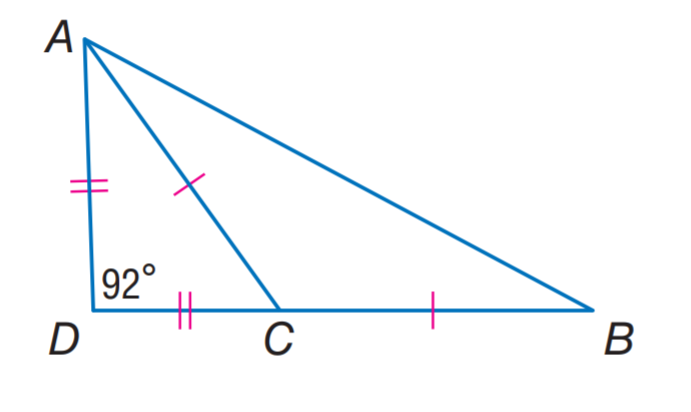

In [ ]:
sample[1]['content'][0]['image']

In [ ]:
output = generate_text_from_sample(model, processor, sample)
output

'BD'

#### 🎉✨ The model has successfully learned to respond to the queries as specified in the dataset. We've achieved our goal! 🎉✨